In [1]:
import os
print(os.getcwd())


C:\Users\mahmoody\Desktop\gait_project\notebooks


synthetic signals for right and left foot motion

In [4]:
import numpy as np
import pandas as pd
fs = 100
time = np.arange(0 , 10 , 1/fs)

right_z = 0.02 * np.sin(2 * np.pi * time * 1.2) + 0.01
left_z = 0.02 * np.sin(2 * np.pi * time * 1.2 + np.pi) + 0.01

right_z += np.random.normal(0 , 0.002 , len(time))
left_z += np.random.normal(0 , 0.002 , len(time))

df = pd.DataFrame({
    "time" : time,
    "foot_right_z_m" : right_z,
    "foot_left_z_m" : left_z
})

df.to_csv("../data/synthetic_gait.csv", index = False)
print("done")
df.head()

done


,time,foot_right_z_m,foot_left_z_m
0,0.00,0.009324,0.012362
1,0.01,0.011981,0.006470
2,0.02,0.013435,0.006984
3,0.03,0.014017,0.004608
4,0.04,0.017352,0.004118


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("../data/synthetic_gait.csv")
df.head()

,time,foot_right_z_m,foot_left_z_m
0,0.00,0.009324,0.012362
1,0.01,0.011981,0.006470
2,0.02,0.013435,0.006984
3,0.03,0.014017,0.004608
4,0.04,0.017352,0.004118


height trajectories for both feet

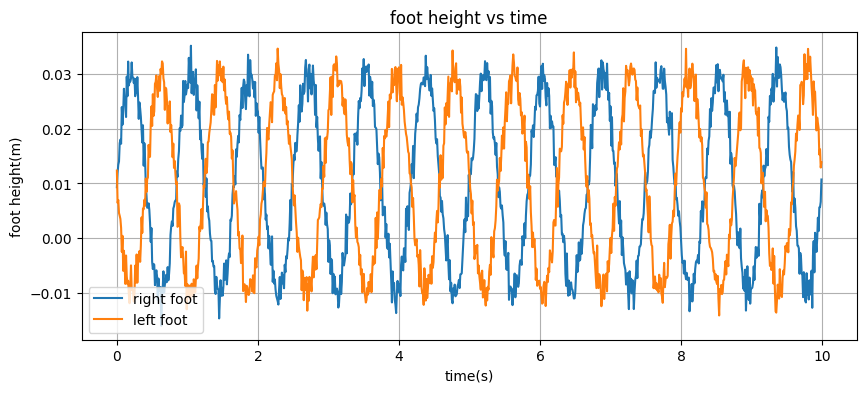

In [8]:
time = df["time"].values
right_z = df["foot_right_z_m"].values
left_z = df["foot_left_z_m"].values

plt.figure(figsize = (10,4))
plt.plot(time ,right_z ,label = "right foot")
plt.plot(time ,left_z , label = "left foot")

plt.xlabel("time(s)")
plt.ylabel("foot height(m)")
plt.title("foot height vs time")
plt.legend()
plt.grid(True)

heel strike points for Right foot

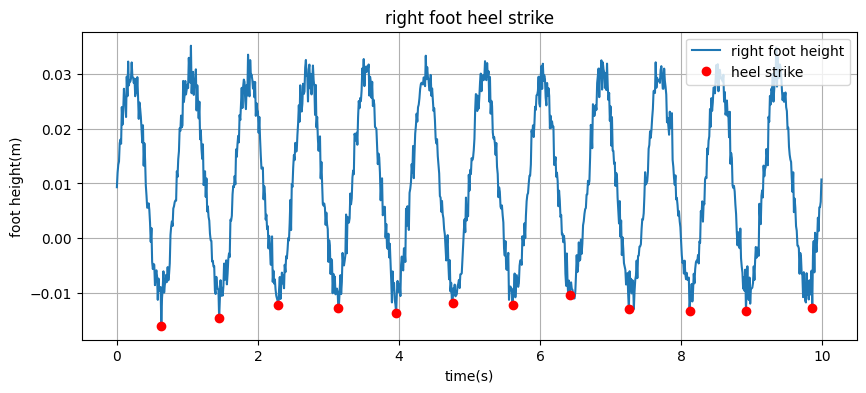

In [10]:
from scipy.signal import find_peaks

inverted_right = -right_z

peaks, _ = find_peaks(inverted_right , distance = 80)
plt.figure(figsize = (10,4))
plt.plot(time ,right_z ,label = "right foot height")
plt.plot(time[peaks] ,right_z[peaks] ,"ro" ,label = "heel strike")
plt.xlabel("time(s)")
plt.ylabel("foot height(m)")
plt.title("right foot heel strike")
plt.legend()
plt.grid(True)
plt.show()

heel strike points for both feet

right hs times: [0.63 1.45 2.29 3.14 3.96 4.76 5.61 6.42 7.26 8.12 8.92 9.86]
left hs times: [0.18 0.99 1.83 2.7  3.53 4.35 5.23 6.03 6.87 7.74 8.54 9.35]


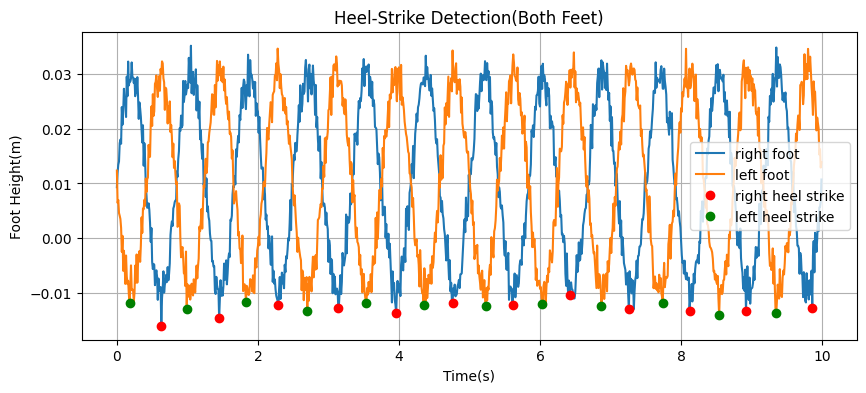

In [12]:
peaks_r, _ = find_peaks(-right_z , distance = 80)
hs_t_r = time[peaks_r]

peaks_l, _ = find_peaks(-left_z , distance = 80)
hs_t_l = time[peaks_l] 

print("right hs times:" , np.round(hs_t_r,3))
print("left hs times:" , np.round(hs_t_l,3))

plt.figure(figsize = (10,4))
plt.plot(time, right_z, label = "right foot")
plt.plot(time, left_z, label = "left foot")
plt.plot(hs_t_r ,right_z[peaks_r], "ro" , label = "right heel strike")
plt.plot(hs_t_l, left_z[peaks_l] , "go" , label = "left heel strike")
plt.xlabel("Time(s)")
plt.ylabel("Foot Height(m)")
plt.title("Heel-Strike Detection(Both Feet)")
plt.legend()
plt.grid(True)
plt.show()

metrics (stride time and cadence)

In [14]:
# Calculating the mean and standard deviation

def mean_and_std (x):
    return np.nanmean(x) , np.nanstd(x)

# Calculating the stride time

stride_r = np.diff(hs_t_r)
stride_l = np.diff(hs_t_l)
m_stride_r , s_stride_r = mean_and_std(stride_r)
m_stride_l , s_stride_l = mean_and_std(stride_l)

# calculating cadence

cadence_r = 120 / m_stride_r
cadence_l = 120 / m_stride_l
cadence_mean = np.nanmean([cadence_r, cadence_l])

# Normal or Irregular Walking Pattern

std_threshold = 0.05
status_r = "normal" if s_stride_r < std_threshold else "irregular"
status_l = "normal" if s_stride_l < std_threshold else "irregular"

print("Gait Summary Report:")
print(f"Right Stride Time : {m_stride_r:.3f} ± {s_stride_r:.3f} sec   →  {status_r}")
print(f"Left  Stride Time : {m_stride_l:.3f} ± {s_stride_l:.3f} sec   →  {status_l}")
print(f"Cadence (average) : {cadence_mean:.1f} steps/min")
if 70 < cadence_mean < 90 :
        print("slow walking")
elif 90 < cadence_mean < 120 :
        print("normal walking")
elif 120 < cadence_mean < 150 :
        print("fast walking")

Gait Summary Report:
Right Stride Time : 0.839 ± 0.038 sec   →  normal
Left  Stride Time : 0.834 ± 0.028 sec   →  normal
Cadence (average) : 143.5 steps/min
fast walking


Detecting Heel-Strike and Toe-Off Events and Calculating Stance Phase Percentage

In [61]:
thresh = 0.01 #meter
# z > thresh   swing phase
# z < thresh   stance phase
stance_mask_r = right_z <= thresh
stance_mask_l = left_z <= thresh

stance_percent_r = 100 * stance_mask_r.mean()
stance_percent_l = 100 * stance_mask_l.mean()

def detect_hs_to(stance_mask , time):
    transition = np.diff(stance_mask.astype(int))
    #transition = +1  heel strike
    # transition = -1  toe off
    hs_idx = np.where(transition == 1)[0] +1
    to_idx = np.where(transition == -1)[0] + 1
    return time[hs_idx] , time[to_idx]

hs_r , to_r = detect_hs_to(stance_mask_r , time)
hs_l , to_l = detect_hs_to(stance_mask_l , time)

print(f"stance right : {stance_percent_r:.1f}%\n")
print(f"stance left : {stance_percent_l:.1f}%\n")
print(f"right heel strike : {np.round(hs_r,3)}\n")
print(f"right toe off : {np.round(to_r,3)}\n")
print(f"left heel strike : {np.round(hs_l,3)}\n")
print(f"left toe off : {np.round(to_l,3)}\n")

stance right : 50.8%

stance left : 49.8%

right heel strike : [0.41 1.23 1.26 1.28 1.68 2.08 2.92 3.74 3.77 4.58 5.   5.41 6.26 6.69
 7.07 7.1  7.5  7.91 7.93 8.73 9.58 9.6 ]

right toe off : [0.01 0.85 1.24 1.27 1.67 1.69 2.5  3.34 3.76 4.17 4.99 5.01 5.84 6.68
 6.7  7.08 7.49 7.51 7.92 8.34 9.17 9.59 9.99]

left heel strike : [0.01 0.42 0.84 0.86 1.66 2.1  2.5  3.34 3.36 3.76 4.18 4.58 5.01 5.4
 5.82 5.85 6.25 6.66 6.68 7.5  7.93 8.33 9.17]

left toe off : [0.41 0.43 0.85 1.25 2.08 2.11 2.93 3.35 3.75 3.77 4.57 4.59 5.39 5.42
 5.83 6.24 6.27 6.67 7.08 7.92 7.94 8.75 9.59]

